In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from collections import defaultdict, Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

grievances_df = pd.read_csv('/content/gdrive/MyDrive/DSSI/Palm_Oil_Grievances/Data/palm_oil_grievance_logs.csv')

Mounted at /content/gdrive


In [3]:
grievances_df.iloc[311]

,311
pk,312
source,Golden Agri-Resources
internal_id,147
status,Closed
submitted_on,5/7/2021
accepted_on,NaN
last_updated_on,3/15/2024
country,NaN
region,NaN
complainants,Eyes on the Forest (EoF)


# Load Data, Topic Words, Topic Distribution, WordClouds

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loaded 430 grievances, 387 with valid summaries
Vocabulary size: 1270
Number of documents: 387
Matrix density: 0.018
Iteration 1: Log-likelihood = -64734.91
Iteration 6: Log-likelihood = -62158.18
Iteration 11: Log-likelihood = -61205.22
Iteration 16: Log-likelihood = -60645.23
Iteration 21: Log-likelihood = -60264.00
Iteration 26: Log-likelihood = -59971.30
Topic 0: 0.924*"chain" + 0.904*"forests" + 0.891*"clearance" + 0.855*"sawit" + 0.751*"supply" + 0.684*"supply chain" + 0.662*"west" + 0.651*"products" + 0.582*"leuser" + 0.548*"west kalimantan"
Topic 1: 5.390*"concession" + 5.266*"earth" + 4.632*"rapid" + 3.459*"earth rapid" + 2.544*"total" + 2.110*"development" + 1.568*"sdn" + 1.407*"hectares" + 1.397*"may" + 1.122*"according"
Topic 2: 1.047*"complainants" + 0.977*"planting" + 0.968*"rights" + 0.922*"informed" + 0.918*"consent" + 0.834*"criteria" + 0.808*"npp" + 0.804*"hgu" + 0.790*"operations" + 0.772*"conservation"
Topic 3: 2.228*"mill" + 1.079*"fruit" + 0.913*"ptpn" + 0.913*"pe

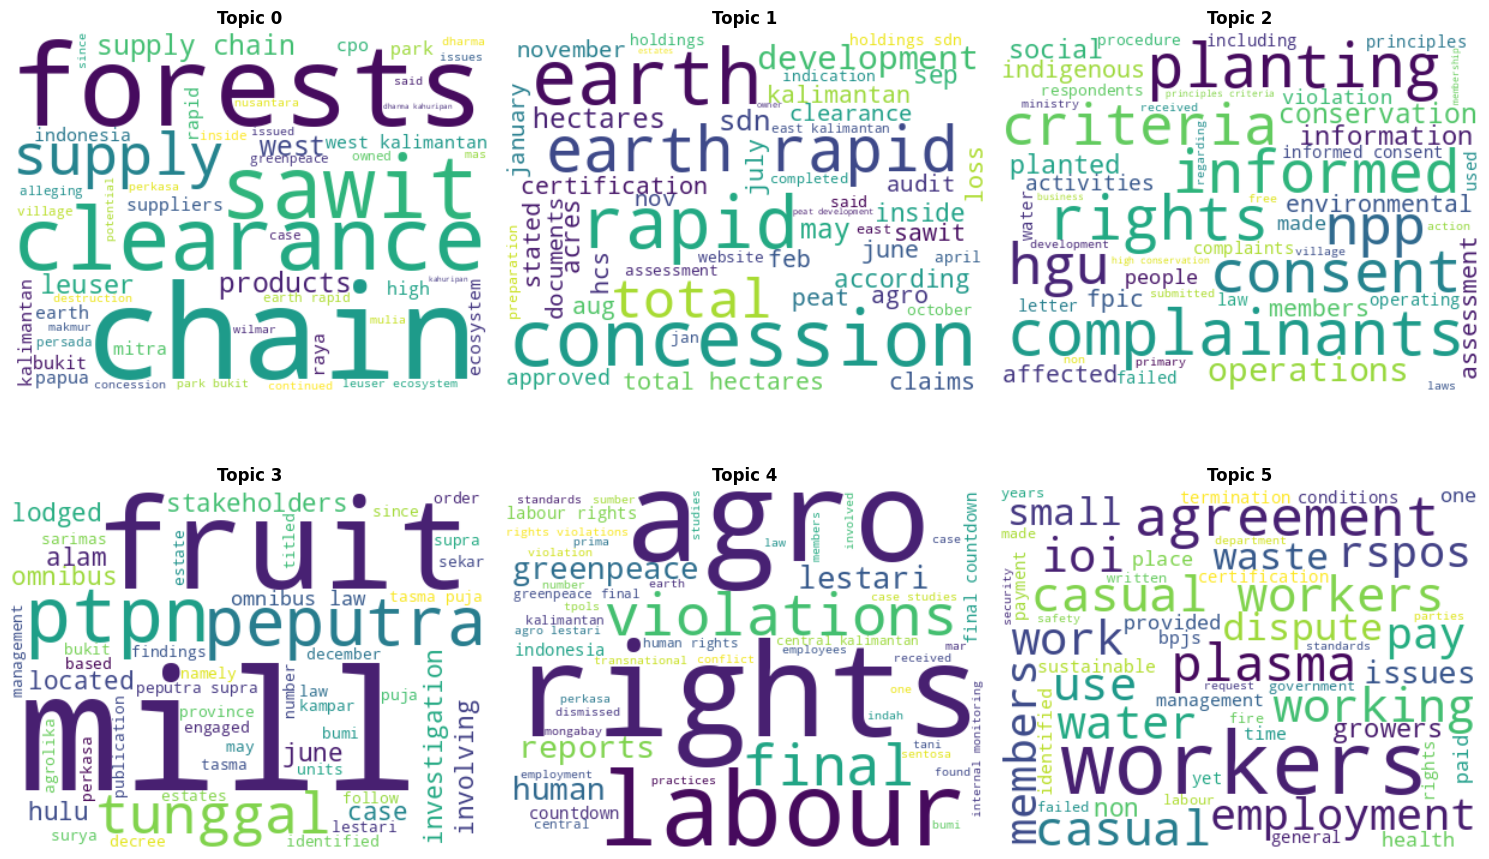

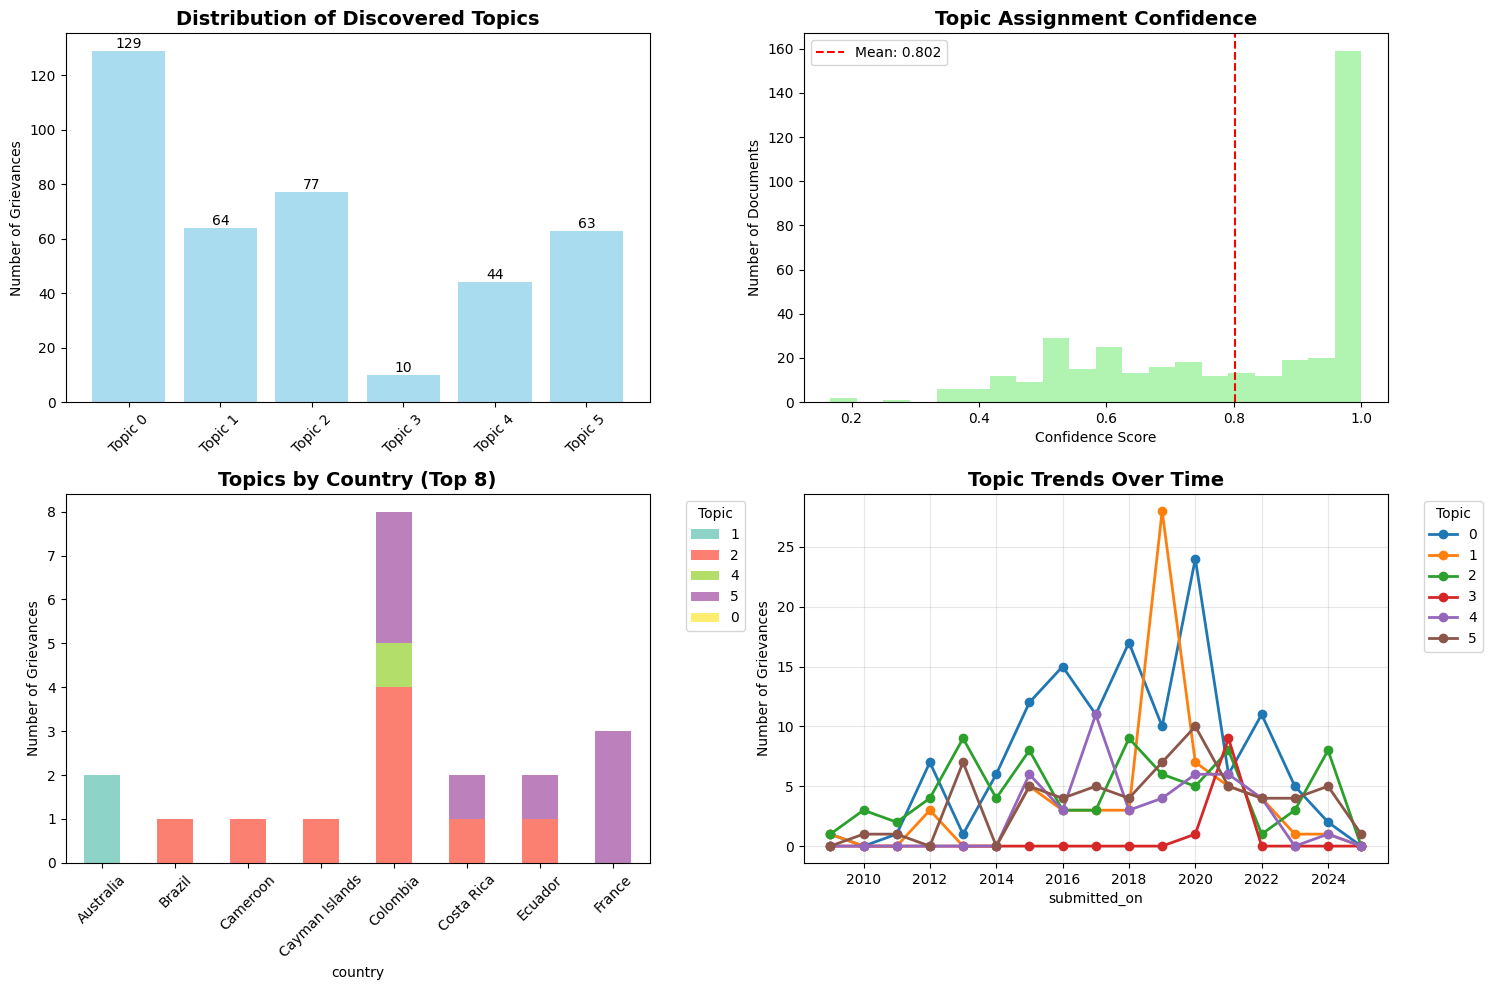

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from typing import List, Tuple, Dict
import warnings
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# Download stopwords if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

class EfficientPLSA:
    def __init__(self, n_topics: int = 6, max_iter: int = 50, tol: float = 1e-4, random_state: int = 42):
        self.n_topics = n_topics
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        # Model parameters
        self.P_z_d = None  # P(z|d) - document-topic distribution
        self.P_w_z = None  # P(w|z) - topic-word distribution

        # Data storage
        self.doc_word_matrix = None
        self.vocabulary = None
        self.vectorizer = None
        self.n_docs = None
        self.n_words = None

        # Training history
        self.log_likelihood_history = []

        # Custom stopwords
        self.custom_stopwords = self._get_custom_stopwords()

    def _get_custom_stopwords(self):
        """Get comprehensive stopwords including domain-specific terms"""
        # Base English stopwords
        english_stopwords = set(stopwords.words('english'))

        # Add additional stopwords based on the topic analysis
        stopwords_extra = [
            'alleged', 'rspo', 'company', 'subsidiary', 'plantation', 'national', 'reported', 'group', 'allegations',
            'report', 'palm', 'oil', 'palm oil', 'deforestation', 'gar', 'progress', 'conducted', "process", "hcv", "assessment"
            'earth', 'mighty', 'response', 'mighty earth', 'land', 'complaint', 'member', 'mentioned', 'grievance',
            'complainant', 'respondent', 'alleges', 'complainant alleges', "clearing", "cleared", "ran", "areas",
            'community', 'communities', 'land clearing', 'eof', 'forest', 'published', 'bhd', 'jaya', 'linked',
            'companies', 'illegal', 'riau', 'investigations', 'plantations', 'within', 'daily','indications', 'ffb',
            'supplier', 'area', 'local', 'new', 'principle', 'lands', 'customary', 'allegedly', 'process'
            'workers', 'river', 'compensation', 'union', 'also', 'without', 'period', 'prior', 'due'
        ]

        # Combine all stopwords
        all_stopwords = english_stopwords.union(set(stopwords_extra))

        return all_stopwords

    def _preprocess_grievance_text(self, texts: List[str]) -> List[str]:
        processed_texts = []

        for text in texts:
            if pd.isna(text) or text == '':
                processed_texts.append('')
                continue

            # Minimal cleaning - preserve structure
            text = text.lower()
            text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
            text = re.sub(r'\s+', ' ', text)      # Multiple spaces to single
            text = text.strip()

            # Remove custom stopwords at text level
            words = text.split()
            filtered_words = [word for word in words if word not in self.custom_stopwords]
            text = ' '.join(filtered_words)

            processed_texts.append(text)

        return processed_texts

    def _smart_initialization(self):
        np.random.seed(self.random_state)

        # Initialize P(z|d) with some structure
        # Use k-means-like initialization
        from sklearn.cluster import KMeans

        # Quick clustering to get initial topic assignments
        if self.n_docs > self.n_topics:
            # Use a subset of features for initial clustering
            subset_features = min(100, self.n_words)
            subset_matrix = self.doc_word_matrix[:, :subset_features]

            try:
                kmeans = KMeans(n_clusters=self.n_topics, random_state=self.random_state, n_init=1)
                cluster_labels = kmeans.fit_predict(subset_matrix)

                # Initialize P(z|d) based on cluster assignments
                self.P_z_d = np.zeros((self.n_docs, self.n_topics))
                for doc_idx, cluster in enumerate(cluster_labels):
                    self.P_z_d[doc_idx, cluster] = 0.9
                    # Add small probability for other topics
                    for other_topic in range(self.n_topics):
                        if other_topic != cluster:
                            self.P_z_d[doc_idx, other_topic] = 0.1 / (self.n_topics - 1)
            except:
                # Fallback to random initialization
                self.P_z_d = np.random.dirichlet(np.ones(self.n_topics), self.n_docs)
        else:
            self.P_z_d = np.random.dirichlet(np.ones(self.n_topics), self.n_docs)

        # Initialize P(w|z) with slight bias toward frequent words
        word_frequencies = np.array(self.doc_word_matrix.sum(axis=0)).flatten()

        self.P_w_z = np.zeros((self.n_words, self.n_topics))
        for z in range(self.n_topics):
            # Add small bias toward frequent words
            topic_weights = word_frequencies + np.random.exponential(1, self.n_words)
            self.P_w_z[:, z] = topic_weights / topic_weights.sum()

    def _efficient_e_step(self):
        # P(z|d,w) = P(w|z) * P(z|d) / P(w|d)
        P_z_dw = np.zeros((self.n_topics, self.n_docs, self.n_words))

        # Vectorized computation for non-zero entries only
        for d in range(self.n_docs):
            # Get non-zero words for this document
            nonzero_words = np.where(self.doc_word_matrix[d, :] > 0)[0]

            if len(nonzero_words) == 0:
                continue

            # Compute for non-zero words only
            for w in nonzero_words:
                # Numerator: P(w|z) * P(z|d)
                numerator = self.P_w_z[w, :] * self.P_z_d[d, :]
                # Denominator: P(w|d) = sum_z P(w|z) * P(z|d)
                denominator = np.sum(numerator)

                if denominator > 1e-10:  # Avoid division by zero
                    P_z_dw[:, d, w] = numerator / denominator

        return P_z_dw

    def _efficient_m_step(self, P_z_dw):
        # Update P(w|z)
        for z in range(self.n_topics):
            numerator = np.sum(self.doc_word_matrix * P_z_dw[z, :, :], axis=0)
            denominator = np.sum(self.doc_word_matrix * P_z_dw[z, :, :])

            if denominator > 1e-10:
                self.P_w_z[:, z] = numerator / denominator
            else:
                # Fallback to uniform distribution
                self.P_w_z[:, z] = 1.0 / self.n_words

        # Update P(z|d)
        for d in range(self.n_docs):
            numerator = np.sum(self.doc_word_matrix[d, :] * P_z_dw[:, d, :], axis=1)
            denominator = np.sum(self.doc_word_matrix[d, :])

            if denominator > 1e-10:
                self.P_z_d[d, :] = numerator / denominator
            else:
                # Fallback to uniform distribution
                self.P_z_d[d, :] = 1.0 / self.n_topics

        # Normalize to ensure probability constraints
        self.P_w_z = normalize(self.P_w_z, axis=0, norm='l1')
        self.P_z_d = normalize(self.P_z_d, axis=1, norm='l1')

    def _compute_log_likelihood(self):
        log_likelihood = 0.0

        for d in range(self.n_docs):
            nonzero_words = np.where(self.doc_word_matrix[d, :] > 0)[0]

            for w in nonzero_words:
                # P(w|d) = sum_z P(w|z) * P(z|d)
                p_w_d = np.sum(self.P_w_z[w, :] * self.P_z_d[d, :])
                if p_w_d > 1e-10:
                    log_likelihood += self.doc_word_matrix[d, w] * np.log(p_w_d)

        return log_likelihood

    def fit(self, documents: List[str], min_df: int = 3, max_df: float = 0.8, max_features: int = 1500):
        processed_docs = self._preprocess_grievance_text(documents)

        # Create document-term matrix with custom stopwords
        self.vectorizer = CountVectorizer(
            min_df=min_df,           # Must appear in at least 3 documents
            max_df=max_df,           # Ignore overly common words
            max_features=max_features, # Limit vocabulary size for efficiency
            stop_words=list(self.custom_stopwords),  # Use custom stopwords
            token_pattern=r'\b[a-zA-Z]{3,}\b',  # Only words with 3+ letters
            ngram_range=(1, 2)       # Include bigrams
        )

        self.doc_word_matrix = self.vectorizer.fit_transform(processed_docs).toarray()
        self.vocabulary = self.vectorizer.get_feature_names_out()
        self.n_docs, self.n_words = self.doc_word_matrix.shape

        print(f"Vocabulary size: {self.n_words}")
        print(f"Number of documents: {self.n_docs}")
        print(f"Matrix density: {np.count_nonzero(self.doc_word_matrix) / (self.n_docs * self.n_words):.3f}")

        # Smart initialization
        self._smart_initialization()

        # EM algorithm
        prev_log_likelihood = float('-inf')

        for iteration in range(self.max_iter):
            # E-step
            P_z_dw = self._efficient_e_step()

            # M-step
            self._efficient_m_step(P_z_dw)

            # Check convergence every 5 iterations
            if iteration % 5 == 0:
                log_likelihood = self._compute_log_likelihood()
                self.log_likelihood_history.append(log_likelihood)

                print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.2f}")

                # Check for convergence
                if abs(log_likelihood - prev_log_likelihood) < self.tol:
                    print(f"Converged after {iteration + 1} iterations")
                    break

                prev_log_likelihood = log_likelihood

        return self

    def get_top_words(self, n_words: int = 10) -> List[List[Tuple[str, float]]]:
        if self.P_w_z is None:
            raise ValueError("Model must be fitted first")

        top_words = []
        for z in range(self.n_topics):
            word_probs = [(self.vocabulary[w], self.P_w_z[w, z])
                         for w in range(self.n_words)]
            word_probs.sort(key=lambda x: x[1], reverse=True)
            top_words.append(word_probs[:n_words])

        return top_words

    def get_lda_style_topics(self, n_words: int = 10) -> List[str]:
        if self.P_w_z is None:
            raise ValueError("Model must be fitted first")

        lda_topics = []
        for z in range(self.n_topics):
            # Get word probabilities for this topic
            word_probs = [(self.vocabulary[w], self.P_w_z[w, z])
                         for w in range(self.n_words)]
            word_probs.sort(key=lambda x: x[1], reverse=True)

            # Format as LDA-style topic
            terms = []
            for word, prob in word_probs[:n_words]:
                # Convert probability to coefficient-like format
                coef = prob * 100  # Scale up for readability
                terms.append(f"{coef:.3f}*\"{word}\"")

            topic_str = f"Topic {z}: " + " + ".join(terms)
            lda_topics.append(topic_str)

        return lda_topics

    def predict_topic_distribution(self) -> np.ndarray:
        if self.P_z_d is None:
            raise ValueError("Model must be fitted first")
        return self.P_z_d.copy()

    def predict_dominant_topics(self) -> np.ndarray:
        if self.P_z_d is None:
            raise ValueError("Model must be fitted first")
        return np.argmax(self.P_z_d, axis=1)

    def analyze_topics(self, df: pd.DataFrame, summary_col: str = 'summary') -> Dict:
        if self.P_z_d is None:
            raise ValueError("Model must be fitted first")

        # Get topic assignments
        topic_assignments = self.predict_dominant_topics()
        topic_distributions = self.predict_topic_distribution()

        # Create analysis dataframe
        df_analysis = df.copy()
        df_analysis['dominant_topic'] = topic_assignments
        df_analysis['topic_confidence'] = np.max(topic_distributions, axis=1)

        # Add individual topic probabilities
        for i in range(self.n_topics):
            df_analysis[f'topic_{i}_prob'] = topic_distributions[:, i]

        # Analysis results
        analysis = {
            'topic_counts': Counter(topic_assignments),
            'avg_confidence': np.mean(np.max(topic_distributions, axis=1)),
            'topic_by_country': df_analysis.groupby(['country', 'dominant_topic']).size().unstack(fill_value=0),
            'topic_by_status': df_analysis.groupby(['status', 'dominant_topic']).size().unstack(fill_value=0),
            'topic_by_year': df_analysis.groupby([pd.to_datetime(df_analysis['submitted_on']).dt.year, 'dominant_topic']).size().unstack(fill_value=0)
        }

        return analysis, df_analysis

    def print_discovered_topics(self, top_words: List[List[Tuple[str, float]]]):
        # Print in LDA-style format
        lda_topics = self.get_lda_style_topics(n_words=10)
        for topic_str in lda_topics:
            print(topic_str)

    def create_wordclouds(self, figsize=(15, 10)):
        if self.P_w_z is None:
            raise ValueError("Model must be fitted first")

        # Calculate number of rows and columns for subplots
        n_cols = 3
        n_rows = (self.n_topics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

        # Flatten axes array for easier indexing
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()

        for z in range(self.n_topics):
            # Get word probabilities for this topic
            word_freq = {}
            for w in range(self.n_words):
                word = self.vocabulary[w]
                # Double-check that word is not in stopwords for wordcloud
                if (self.P_w_z[w, z] > 0 and
                    word not in self.custom_stopwords and
                    len(word) > 2):  # Additional length filter
                    word_freq[word] = self.P_w_z[w, z]

            # Create wordcloud with additional stopwords filtering
            if word_freq:
                wordcloud = WordCloud(
                    width=400,
                    height=300,
                    background_color='white',
                    colormap='viridis',
                    max_words=50,
                    relative_scaling=0.5,
                    random_state=42,
                    stopwords=self.custom_stopwords,  # Additional stopwords for wordcloud
                    collocations=False  # Avoid repeated phrases
                ).generate_from_frequencies(word_freq)

                axes[z].imshow(wordcloud, interpolation='bilinear')
                axes[z].set_title(f'Topic {z}', fontsize=12, fontweight='bold')
                axes[z].axis('off')
            else:
                axes[z].text(0.5, 0.5, 'No words', ha='center', va='center')
                axes[z].set_title(f'Topic {z}', fontsize=12, fontweight='bold')
                axes[z].axis('off')

        # Hide empty subplots
        for i in range(self.n_topics, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        return fig

    def plot_results(self, analysis: Dict, df_analysis: pd.DataFrame):
        wordcloud_fig = self.create_wordclouds()

        # Create other analysis plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Topic distribution
        topic_counts = analysis['topic_counts']
        topics = [f"Topic {i}" for i in range(self.n_topics)]
        counts = [topic_counts.get(i, 0) for i in range(self.n_topics)]

        bars = axes[0, 0].bar(topics, counts, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Distribution of Discovered Topics', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Number of Grievances')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{count}', ha='center', va='bottom')

        # Topic confidence distribution
        axes[0, 1].hist(df_analysis['topic_confidence'], bins=20, alpha=0.7, color='lightgreen')
        axes[0, 1].set_title('Topic Assignment Confidence', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Confidence Score')
        axes[0, 1].set_ylabel('Number of Documents')
        axes[0, 1].axvline(df_analysis['topic_confidence'].mean(), color='red', linestyle='--',
                          label=f'Mean: {df_analysis["topic_confidence"].mean():.3f}')
        axes[0, 1].legend()

        # Topics by country (if available)
        if 'country' in df_analysis.columns and not analysis['topic_by_country'].empty:
            country_topic = analysis['topic_by_country'].head(8)
            country_topic.plot(kind='bar', stacked=True, ax=axes[1, 0], colormap='Set3')
            axes[1, 0].set_title('Topics by Country (Top 8)', fontsize=14, fontweight='bold')
            axes[1, 0].set_ylabel('Number of Grievances')
            axes[1, 0].legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[1, 0].tick_params(axis='x', rotation=45)
        else:
            axes[1, 0].text(0.5, 0.5, 'Country data not available', ha='center', va='center')
            axes[1, 0].set_title('Topics by Country', fontsize=14, fontweight='bold')

        # Topics over time (if available)
        if 'submitted_on' in df_analysis.columns and not analysis['topic_by_year'].empty:
            year_topic = analysis['topic_by_year']
            year_topic.plot(kind='line', marker='o', ax=axes[1, 1], linewidth=2, markersize=6)
            axes[1, 1].set_title('Topic Trends Over Time', fontsize=14, fontweight='bold')
            axes[1, 1].set_ylabel('Number of Grievances')
            axes[1, 1].legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Time data not available', ha='center', va='center')
            axes[1, 1].set_title('Topic Trends Over Time', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        return fig, wordcloud_fig


def run_plsa_analysis(csv_file: str = 'palm_oil_grievance_logs.csv', n_topics: int = 6):
    try:
        # Load data
        df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
        df_clean = df.dropna(subset=['summary'])

        print(f"Loaded {len(df)} grievances, {len(df_clean)} with valid summaries")

        # Initialize and fit PLSA
        plsa = EfficientPLSA(n_topics=n_topics, max_iter=30, tol=1e-4)
        plsa.fit(df_clean['summary'].tolist())

        # Get discovered topics
        top_words = plsa.get_top_words(n_words=12)

        # Print discovered topics
        plsa.print_discovered_topics(top_words)

        # Analyze topics
        analysis, df_analysis = plsa.analyze_topics(df_clean)

        # Print summary
        print(f"- Average topic confidence: {analysis['avg_confidence']:.3f}")
        print(f"- Topic distribution: {dict(analysis['topic_counts'])}")

        # Plot results
        analysis_fig, _ = plsa.plot_results(analysis, df_analysis)

        return plsa, analysis, df_analysis

    except Exception as e:
        print(f"Error: {e}")
        return None, None, None


if __name__ == "__main__":
    plsa, analysis, df_analysis = run_plsa_analysis()

## Coherence Score

In [5]:
import numpy as np

def topic_coherence(plsa_model, n_words=10):
    scores = []

    for topic in range(plsa_model.n_topics):
        word_probs = plsa_model.P_w_z[:, topic]
        top_words = np.argsort(word_probs)[-n_words:]

        coherence = 0.0
        pairs = 0

        for i in range(len(top_words)):
            for j in range(i + 1, len(top_words)):
                word_i, word_j = top_words[i], top_words[j]

                # Count docs with both words
                both = np.sum((plsa_model.doc_word_matrix[:, word_i] > 0) &
                            (plsa_model.doc_word_matrix[:, word_j] > 0))

                # Count docs with first word
                single = np.sum(plsa_model.doc_word_matrix[:, word_i] > 0)

                if single > 0:
                    coherence += np.log((both + 1e-10) / single)
                    pairs += 1

        score = coherence / pairs if pairs > 0 else 0.0
        scores.append(score)

        print(f"Topic {topic}: {score:.3f}")

    return scores

scores = topic_coherence(plsa)

Topic 0: -7.725
Topic 1: -2.030
Topic 2: -2.649
Topic 3: -0.666
Topic 4: -3.799
Topic 5: -9.074


## Data Frame with Results

In [6]:
import pandas as pd
import numpy as np

def create_plsa_results_df(plsa, texts):

    rows = []

    topic_distributions = plsa.P_z_d  # Shape: (n_docs, n_topics)

    for i, doc_topics in enumerate(topic_distributions):
        # Convert to percentages
        topic_percentages = doc_topics * 100

        # Find dominant topic
        dominant_topic = np.argmax(doc_topics)
        dominant_perc = topic_percentages[dominant_topic]

        # Get keywords for dominant topic
        top_words = plsa.get_top_words(10)[dominant_topic]
        topic_keywords = ", ".join([word for word, _ in top_words[:5]])

        # Count how many topics contribute significantly (>10%)
        significant_topics = np.sum(topic_percentages > 10)

        # Check if outlier (no clear dominant topic)
        is_outlier = dominant_perc < 30

        # Create base row
        row = {
            'Document_ID': i,
            'Dominant_Topic': dominant_topic,
            'Perc_Contribution': round(dominant_perc, 2),
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Significant_Topics': significant_topics
        }

        # Add individual topic percentages
        for topic_id in range(plsa.n_topics):
            row[f'Topic_{topic_id}_Perc'] = round(topic_percentages[topic_id], 2)

        # Add binary indicators for topics >10%
        for topic_id in range(plsa.n_topics):
            row[f'Topic_{topic_id}_Indicate'] = 1 if topic_percentages[topic_id] > 10 else 0

        rows.append(row)

    # Create DataFrame
    df = pd.DataFrame(rows)

    # Add summary statistics
    print(f"Created DataFrame with {len(df)} documents")
    print(f"Average dominant topic contribution: {df['Perc_Contribution'].mean():.1f}%")
    print(f"Documents with clear dominant topic (>50%): {(df['Perc_Contribution'] > 50).sum()}")
    print(f"Outlier documents: {df['Is_Outlier'].sum()}")

    return df

def topic_summary(plsa):
    topic_data = []

    for topic_id in range(plsa.n_topics):
        top_words = plsa.get_top_words(10)[topic_id]
        keywords = ", ".join([word for word, _ in top_words[:8]])

        topic_data.append({
            'Topic_ID': topic_id,
            'Top_Keywords': keywords,
            'Top_Word_Prob': top_words[0][1]
        })

    return pd.DataFrame(topic_data)

df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df_clean = df.dropna(subset=['summary'])
original_texts = df_clean['summary'].tolist()
# Usage example:
dominant_topic_df = create_plsa_results_df(plsa, original_texts).reset_index()
topic_summary_df = topic_summary(plsa)
topic_summary_df

Created DataFrame with 387 documents
Average dominant topic contribution: 80.2%
Documents with clear dominant topic (>50%): 351
Outlier documents: 3


,Topic_ID,Top_Keywords,Top_Word_Prob
0,0,"chain, forests, clearance, sawit, supply, supp...",0.009239
1,1,"concession, earth, rapid, earth rapid, total, ...",0.053897
2,2,"complainants, planting, rights, informed, cons...",0.010473
3,3,"mill, fruit, ptpn, peputra, tunggal, stakehold...",0.022278
4,4,"rights, agro, labour, violations, final, repor...",0.035798
5,5,"workers, agreement, plasma, casual, casual wor...",0.041875


In [ ]:
dominant_topic_df

,index,Document_ID,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Significant_Topics,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_5_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate
0,0,0,5,65.59,"workers, agreement, plasma, casual, casual wor...",That the Respondent allegedly transferred the ...,False,3,0.00,10.22,24.19,0.0,0.0,65.59,0,1,1,0,0,1
1,1,1,5,39.56,"workers, agreement, plasma, casual, casual wor...",The Complainant alleges that the Respondent ha...,False,3,7.19,4.95,26.59,0.0,21.7,39.56,0,0,1,0,1,1
2,2,2,2,100.00,"complainants, planting, rights, informed, consent",1.The Complainant alleges that the Respondent ...,False,1,0.00,0.00,100.00,0.0,0.0,0.00,0,0,1,0,0,0
3,3,3,2,50.27,"complainants, planting, rights, informed, consent",The Respondent's Corporate Social Responsibili...,False,3,27.34,0.00,50.27,0.0,0.0,22.39,1,0,1,0,0,1
4,4,4,2,60.69,"complainants, planting, rights, informed, consent",The Complainant alleges that the Respondent br...,False,3,17.81,0.00,60.69,0.0,0.0,21.49,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,382,382,4,100.00,"rights, agro, labour, violations, final",Alleged community rights violations and land c...,False,1,0.00,0.00,0.00,0.0,100.0,0.00,0,0,0,0,1,0
383,383,383,0,100.00,"chain, forests, clearance, sawit, supply","i. PT Rimba Harapan Saksti (RHS), PT Sarana Ti...",False,1,100.00,0.00,0.00,0.0,0.0,0.00,1,0,0,0,0,0
384,384,384,4,70.60,"rights, agro, labour, violations, final",Alleged construction of canal to prepare for d...,False,2,29.40,0.00,0.00,0.0,70.6,0.00,1,0,0,0,1,0
385,385,385,0,100.00,"chain, forests, clearance, sawit, supply",Alleged clearance of potential High Carbon Sto...,False,1,100.00,0.00,0.00,0.0,0.0,0.00,1,0,0,0,0,0


## Converting it to a csv file.

In [ ]:
# Convert to CSV and save
dominant_topic_df.to_csv("pLSA_results.csv",index = False)
from google.colab import files
# files.download("pLSA_results.csv")

## Data Exploration

In [ ]:
print(len(dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3]))

10


In [ ]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3]

,index,Document_ID,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Significant_Topics,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_5_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate
277,277,277,3,73.42,"mill, fruit, ptpn, peputra, tunggal","On 9 June 2020, RAN reported a number of alleg...",False,2,0.0,1.27,25.31,73.42,0.0,0.0,0,0,1,1,0,0
308,308,308,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
309,309,309,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
310,310,310,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
311,311,311,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
312,312,312,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
313,313,313,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
314,314,314,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
315,315,315,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0
316,316,316,3,100.00,"mill, fruit, ptpn, peputra, tunggal","In May/June 2021, Eyes On the Forest (EOF) pub...",False,1,0.0,0.00,0.00,100.00,0.0,0.0,0,0,0,1,0,0


## Avg Dominant Topic Contribution

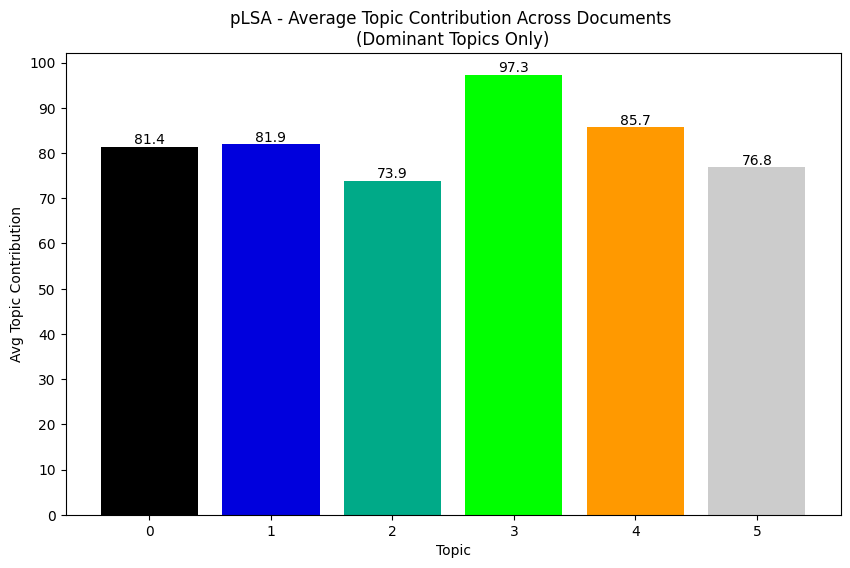

In [ ]:
# Prepare data
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title('pLSA - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

## Dominant Topic Frequency

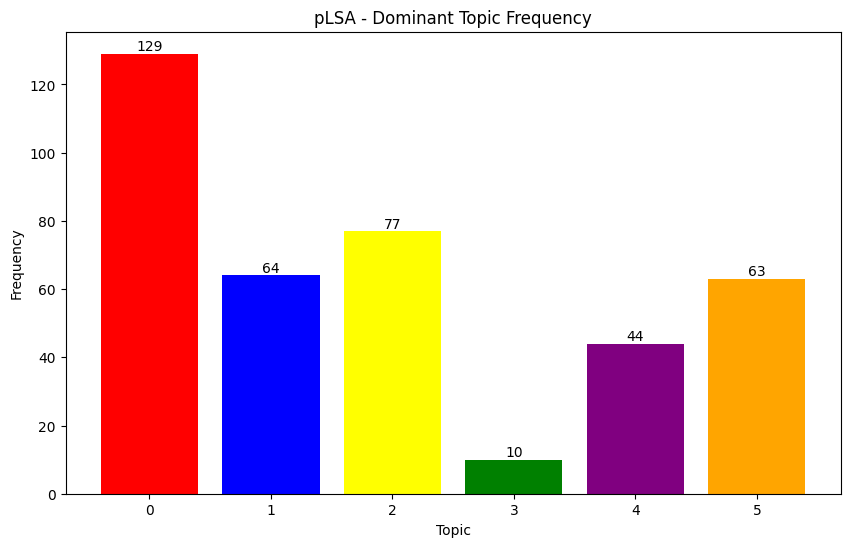

In [ ]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title('pLSA - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Topic Distribution per Doc

In [ ]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['index'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title('pLSA - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

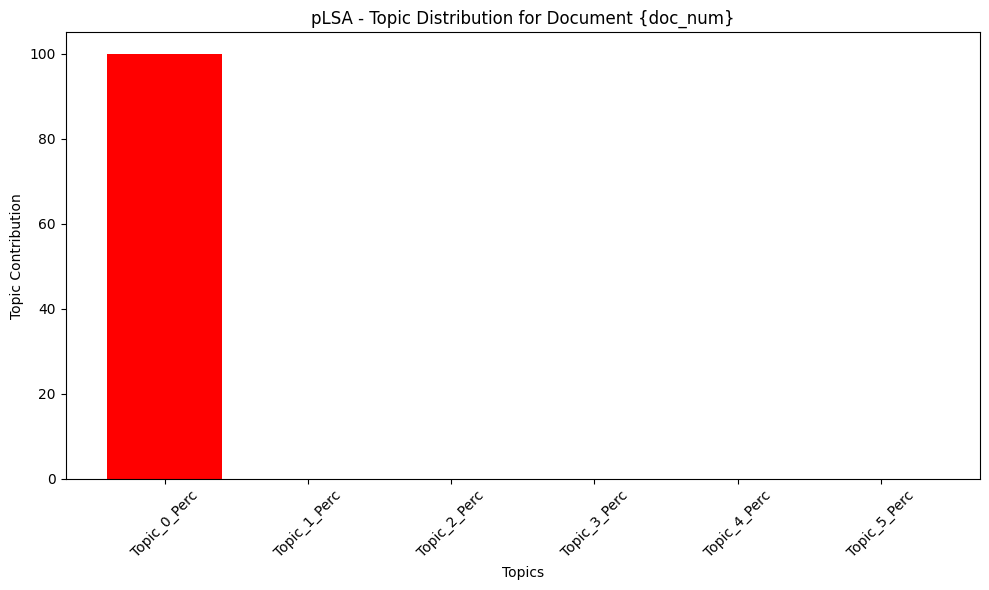

In [ ]:
topic_dist_doc(dominant_topic_df, 6, 234)

##WordClouds

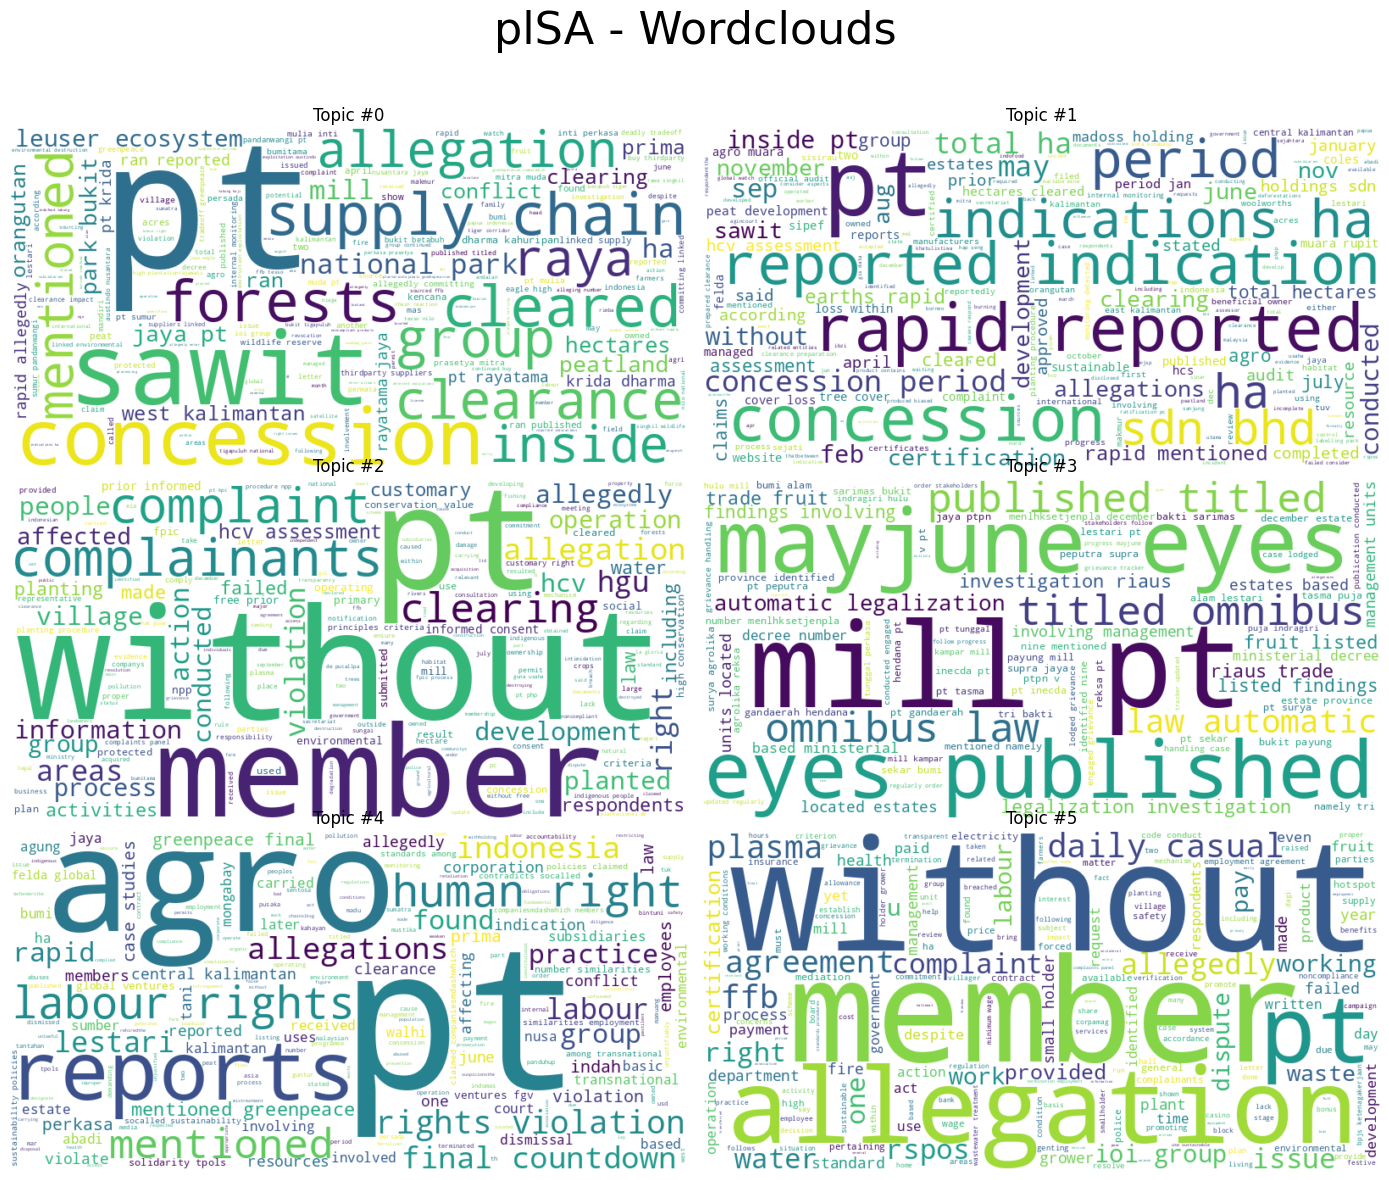

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Add additional stopwords based on the topic analysis
stopwords_extra = ['alleged', 'rspo', 'company', 'subsidiary', 'plantation',
                   'report', 'palm', 'oil', 'palm oil', 'deforestation', 'gar',
                   'earth', 'mighty', 'response', 'mighty earth', 'land',
                   'complainant', 'respondent', 'alleges', 'complainant alleges',
                   'community', 'communities', 'land clearing', 'eof', 'forest',
                   'companies', 'illegal', 'riau', 'investigations', 'plantations',
                   'supplier', 'area', 'local', 'new', 'principle', 'lands',
                   'workers', 'river', 'compensation', 'union']


# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='plSA - Wordclouds', n_topics=6)

## Overall Dominant Topic % share

Text(0, 0.5, 'Number of Documents')

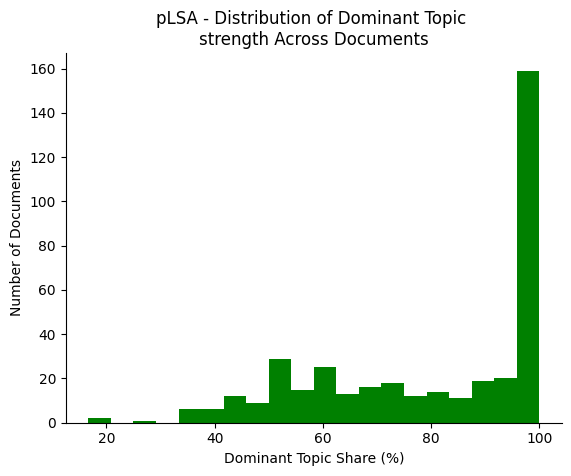

In [ ]:
# Displays every doc's dominant topic share as a percentage compared to its other non-dominant topics
# Basically how much weight the dominant topic have throughout each of the documents
dominant_topic_df['Perc_Contribution'].plot(kind='hist', bins=20, title='Perc_Contribution', color='green')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.title("pLSA - Distribution of Dominant Topic \nstrength Across Documents")
plt.xlabel("Dominant Topic Share (%)")
plt.ylabel("Number of Documents")